In [1]:
# Run code on Anaconda Env.
# Construct data source by downloading 2018 data
import folktables
from folktables import ACSDataSource, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)  # have to use 'download=True' if data not already avaiable locally

features, label, group = ACSIncome.df_to_numpy(acs_data)  # split data into corresponding features, labels, and group



/Users/timothychang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/timothychang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [77]:
def mixRaceRates(data, target_bhn_rate, set_training_size):
    # Input: complete training dataset as numpy array
    # Output: filtered dataset where mix rate of bhn indiviudals satisfies the desired target (+/- 1%)
    # RAC1P column # for ASCIncome task -> 9
    print("\nbhn rate: ", target_bhn_rate)

    # count occurances of BHN in the RAC1P column
    rac1p_values = data[:, 9]
    bhn_count = len(np.where((rac1p_values == 2) | (rac1p_values == 3))[0])
    non_bhn_count = len(rac1p_values) - bhn_count
    print("# bhn: ", bhn_count)
    print("# non-bhn: ", non_bhn_count)

    # calc initial rate of bhn in training set
    initial_rate = bhn_count / len(rac1p_values)
    print("intial rate: ", initial_rate)

    # if the initial rate is within 3% of desired mix rate, return the dataset
    if abs(initial_rate - target_bhn_rate) < 0.03:
        return data, set_training_size

    # if initial rate > target rate: remove bhn rows
    if initial_rate > target_bhn_rate:
        # find indicies of bhn
        target_indicies = np.where((rac1p_values == 2) | (rac1p_values == 3))[0]
        remove_count = 0
        if target_bhn_rate == 0:
            # remove all bhn rows
            remove_count = len(target_indicies)
        else:
            np.random.shuffle(target_indicies)
            # calculate num of bhn rows to remove, then remove specified # of bhn rows
            remove_count = bhn_count + non_bhn_count - int(bhn_count / target_bhn_rate)
        
        data = np.delete(data, target_indicies[:remove_count], axis=0)
    
    else: # initial rate < target rate: remove non-bhn rows
        # find indicies of non-bhn
        target_indicies = np.where((rac1p_values != 2) & (rac1p_values != 3))[0]
        np.random.shuffle(target_indicies)
        # calculate # of non-bhn rows to remove
        remove_count = bhn_count + non_bhn_count - int(bhn_count / target_bhn_rate)
        data = np.delete(data, target_indicies[:remove_count], axis=0)
        
    # recalc and confirm mix rate of bhn in training set
    rac1p_values = data[:, 9]
    bhn_count = len(np.where((rac1p_values == 2) | (rac1p_values == 3))[0])
    updated_rate = bhn_count / len(rac1p_values)
    print("updated training set size: ", len(data))
    print("updated rate: ", updated_rate)
    

    return data, set_training_size


In [78]:
def confusion(pred, label):
    tn, fp, fn, tp = confusion_matrix(label, pred).ravel()
    acc = (tp + tn)/ (tp + tn + fp + fn)
    tpr = tp / (tp + fn)
    fnr = fn / (tp + fn)
    fpr = fp / (fp + tn)
    tnr = tn / (fp + tn)
    return [acc, tpr, fnr, fpr, tnr]

def evaluateMixRate(features, label, group, bhn_rate, set_training_size):
    # randomly split the data into training and testing
    # train-test split: 80/20
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features, label, group, test_size=0.2)

    # reshape y_train into column vector, then concatenate with X_train to reformat training data
    train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

    # filter training data to satisfy desired BHN mix rate
    modified_train_data, set_training_size = mixRaceRates(train_data, bhn_rate, set_training_size)

    new_X_train = modified_train_data[:, :-1] # get all cols except for last one
    new_y_train = modified_train_data[:, -1]  # get only the last col

    # create the pipeline: normalize data, then use logistic regression as classifier
    model = make_pipeline(StandardScaler(), RandomForestClassifier(max_depth=16, min_samples_leaf=3))
    # train the model with the training data
    model.fit(new_X_train, new_y_train)

    # make predictions on test data set
    yhat = model.predict(X_test)

    yhat_wa = yhat[(group_test == 1) | (group_test == 6)]  # all rows from prediction where group=1 (white) or group=6 (asian)
    yhat_bhn = yhat[(group_test == 2) | (group_test == 3)]  # all rows from prediction where group=2 (black) or group=3 (american indian)

    y_test_wa = y_test[(group_test == 1) | (group_test == 6)]  # all rows from test set where group=1 (white) or group=6 (asian)
    y_test_bhn = y_test[(group_test == 2) | (group_test == 3)]  # all rows from test set where group=2 (black) or group=3 (american indian)
    
    # get the acc, tpr, fnr, fpr, tnr data for WA and BHN groups
    wa_data = confusion(yhat_wa, y_test_wa)
    bhn_data = confusion(yhat_bhn, y_test_bhn)
    
    return wa_data, bhn_data, set_training_size

In [79]:
target_bhn_rates = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
set_training_size = 0  # set the size of training set based on 100% BHN mix

# map: % bhn in training set -> [ACC, TPR, FNR, FPR, TNR]
wa_map = {}
bhn_map = {}

for target_rate in target_bhn_rates:
    wa_data, bhn_data, set_training_size = evaluateMixRate(features, label, group, target_rate, set_training_size)
    wa_map[target_rate] = wa_data
    bhn_map[target_rate] = bhn_data

# print results
for i in range(len(target_bhn_rates)):
    target_rate = target_bhn_rates[i]
    print("\n% BHN in training set: ", target_rate * 100)
    print("Accuracy (WA): ", wa_map[target_rate][0])
    print("TPR (WA): ", wa_map[target_rate][1])
    print("FNR (WA): ", wa_map[target_rate][2], " (Pessimistic Underestimation)")
    print("FPR (WA): ", wa_map[target_rate][3], " (Benefit of Doubt)")
    print("TNR (WA): ", wa_map[target_rate][4])

    print("\nAccuracy (BHN): ", bhn_map[target_rate][0])
    print("TPR (BHN): ", bhn_map[target_rate][1])
    print("FNR (BHN): ", bhn_map[target_rate][2], " (Pessimistic Underestimation)")
    print("FPR (BHN): ", bhn_map[target_rate][3], " (Benefit of Doubt)")
    print("TNR (BHN): ", bhn_map[target_rate][4])


bhn rate:  1
# bhn:  7864
# non-bhn:  148668
intial rate:  0.05023892878133544
updated training set size:  7864
updated rate:  1.0

bhn rate:  0.9
# bhn:  7951
# non-bhn:  148581
intial rate:  0.05079472567909437
updated training set size:  8834
updated rate:  0.9000452796015395

bhn rate:  0.8
# bhn:  7945
# non-bhn:  148587
intial rate:  0.050756394858559276
updated training set size:  9931
updated rate:  0.8000201389588159

bhn rate:  0.7
# bhn:  7850
# non-bhn:  148682
intial rate:  0.05014949020008688
updated training set size:  11214
updated rate:  0.7000178348492955

bhn rate:  0.6
# bhn:  7860
# non-bhn:  148672
intial rate:  0.05021337490097871
updated training set size:  13100
updated rate:  0.6

bhn rate:  0.5
# bhn:  7885
# non-bhn:  148647
intial rate:  0.05037308665320829
updated training set size:  15770
updated rate:  0.5

bhn rate:  0.4
# bhn:  7895
# non-bhn:  148637
intial rate:  0.05043697135410012
updated training set size:  19737
updated rate:  0.4000101332522673

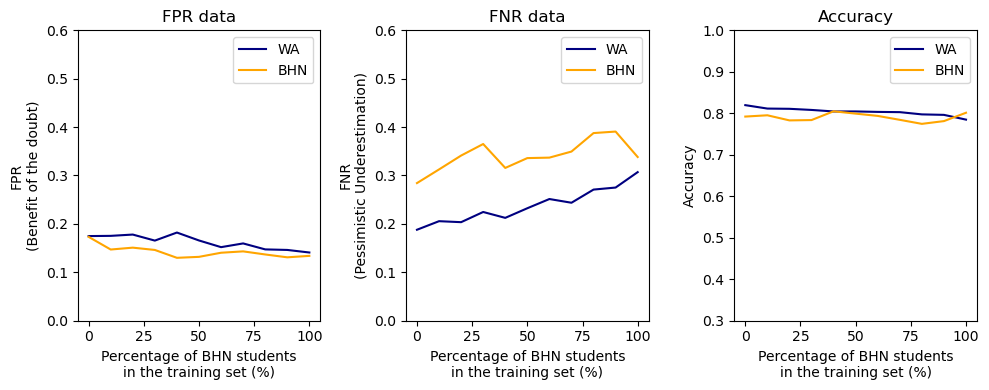

In [80]:
import matplotlib.pyplot as plt

x = [] 
y_FPR_WA = []
y_FPR_BHN = []
y_FNR_WA = []
y_FNR_BHN = []
y_ACC_WA = []
y_ACC_BHN = []

for mix_rate in target_bhn_rates:
    x.append(mix_rate * 100)

    y_FPR_WA.append(wa_map[mix_rate][3])
    y_FPR_BHN.append(bhn_map[mix_rate][3])

    y_FNR_WA.append(wa_map[mix_rate][2])
    y_FNR_BHN.append(bhn_map[mix_rate][2])

    y_ACC_WA.append(wa_map[mix_rate][0])
    y_ACC_BHN.append(bhn_map[mix_rate][0])
    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

# plot data
ax1.plot(x, y_FPR_WA, label="WA", color="navy")
ax1.plot(x, y_FPR_BHN, label="BHN", color="orange")

ax2.plot(x, y_FNR_WA, label="WA", color="navy")
ax2.plot(x, y_FNR_BHN, label="BHN", color="orange")

ax3.plot(x, y_ACC_WA, label="WA", color="navy")
ax3.plot(x, y_ACC_BHN, label="BHN", color="orange")

# add labels and title
ax1.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax1.set_ylabel("FPR\n(Benefit of the doubt)")
ax1.set_title("FPR data")
ax1.legend()
ax1.set_ylim(0, 0.6)

ax2.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax2.set_ylabel("FNR\n(Pessimistic Underestimation)")
ax2.set_title("FNR data")
ax2.legend()
ax2.set_ylim(0, 0.6)

ax3.set_xlabel("Percentage of BHN students\nin the training set (%)")
ax3.set_ylabel("Accuracy")
ax3.set_title("Accuracy")
ax3.legend()
ax3.set_ylim(0.3, 1)

plt.tight_layout()
plt.show()
